# GHZ circuit

This example applies small modifications to the transpiled circuit so that the computation results are completely different from those that would be obtained by running the genuine, unmodified circuit.

This notebook is a step-by-step tutorial and gives additional insights about the example described in Sec. 7.1 of the paper.

Reproducible quantum builds would help detect and mitigate this class of attacks, as explained in the threat model section (see Sec. 5.2). In particular, if transpiled quantum circuits are always bit-for-bit identical, any small modification in the transpiled circuit could be interpreted as a bug potentially affecting the results of the quantum computation.

<div class="alert alert-block alert-info">
It is assumed that you have already configured your token to use IBM Quantum Platform. If not, follow <a href="https://quantum.cloud.ibm.com/docs/en/migration-guides/classic-iqp-to-cloud-iqp#onboard">IBM's instructions here</a>.
</div>
<div class="alert alert-block alert-danger">
This notebook contains cells that will submit jobs to the <a href="https://quantum.cloud.ibm.com/">IBM Quantum Platform</a>. Running these jobs may incur costs if you are on a paid plan.
    
By default, the boolean <code>run_on_ibm</code> prevents these cells from executing. Set it to <code>True</code> to enable execution.
</div>

## Index

1. [Benchmarking circuit](#Benchmarking-circuit)
2. [Reset attack](#Reset-attack)
3. [Modifying a single CZ gate](#Modifying-a-single-CZ-gate)
4. [Running on a real backend](#Running-on-a-real-backend)

In [1]:
import qiskit
import qiskit_ibm_runtime

print(f"Qiskit version: {qiskit.version.get_version_info()}")
print(f"Qiskit IBM Runtime version: {qiskit_ibm_runtime.version.get_version_info()}")

Qiskit version: 2.2.1
Qiskit IBM Runtime version: 0.42.0


In [2]:
run_on_ibm = False
# Number of times quantum circuits are executed on IBM's quantum backend
n_shots = 10_000

---
## Benchmarking circuit

In [3]:
from qiskit import QuantumCircuit, ClassicalRegister

We use a GHZ preparation circuit as benchmarking circuit. We use as many qubits (133) as the largest available quantum backend in the Open Plan of IBM Quantum Platform. First and last qubits are measured in the computational basis. With an ideal circuit we should obtain a uniform distribution.

In [4]:
def gen_benchmarking_circuit(num_qubits):
    qc = QuantumCircuit(num_qubits)
    meas = ClassicalRegister(2, "meas")
    qc.add_register(meas)
    qc.h(0)
    [qc.cx(i, i + 1) for i in range(num_qubits - 1)]
    qc.barrier()
    qc.measure([0, num_qubits - 1], [meas[0], meas[1]])
    return qc

Before validating the attacks on real backends, we use a local simulation with a smaller circuit of 7 qubits.

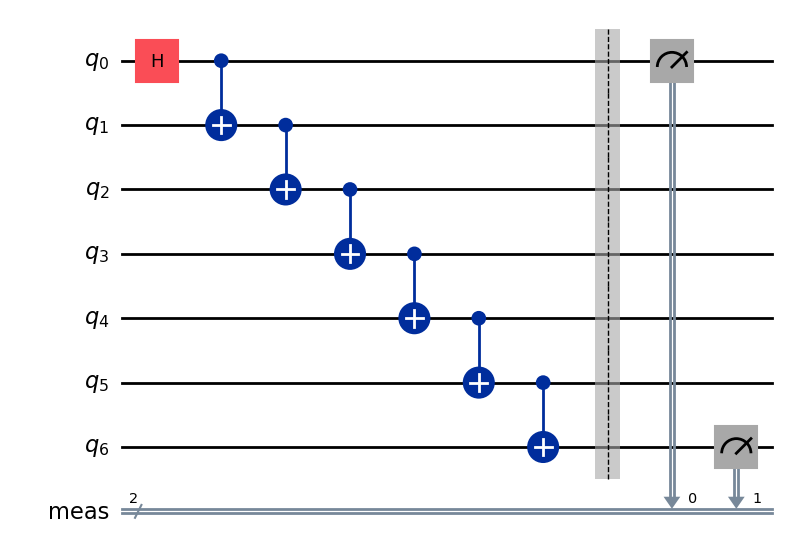

In [5]:
qc = gen_benchmarking_circuit(7)
qc.draw("mpl")

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeTorino
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as SamplerAer
from qiskit_aer.noise import NoiseModel

In [7]:
backend = FakeTorino()

If you have an IBM Quantum Platform account and have followed [the instructions to configure and save it](https://quantum.cloud.ibm.com/docs/en/guides/cloud-setup), you can uncomment the cell below to use the latest noise model from a real quantum backend. Otherwise, feel free to continue with the rest of the notebook using the noise model from the old snapshot.

In [8]:
#service = QiskitRuntimeService()
# Heron r1 QPU with 133 qubits
#backend = service.backend("ibm_torino")

We can simulate locally using the current noise model from the real backend.

In [9]:
noise_model = NoiseModel.from_backend(backend)
sim = AerSimulator(noise_model=noise_model)
sampler_aer = SamplerAer.from_backend(sim)

In [10]:
import secrets
from qiskit import generate_preset_pass_manager

In [11]:
# Random seed fixed for reproducibility. Delete the fixed seed and uncomment the next line for a fresh random seed.
#seed_transpiler = secrets.randbits(64)
seed_transpiler = 1062981512974188944

pm = generate_preset_pass_manager(backend=backend, optimization_level=3, seed_transpiler=seed_transpiler)
isa_qc = pm.run(qc)

In [12]:
results = sampler_aer.run([isa_qc], shots=10_000).result()
counts = results[0].data.meas.get_counts()

In [13]:
from qiskit.visualization import plot_histogram

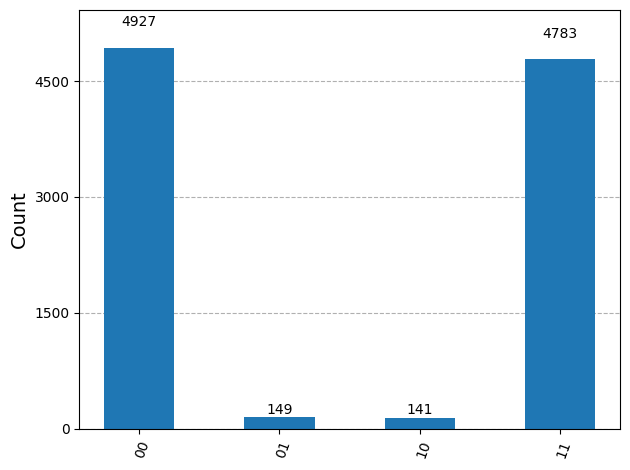

In [14]:
plot_histogram(counts)

As expected, we obtain approximately a uniform distribution with most of the counts for `00` and `11`, and very few errors.

## Reset attack

A very simple but effective attack is to introduce a reset instruction in one of the measured qubits. This destroys the entanglement and transforms the qubit to the state $\ket{0}$, so that the measurement is always 0 (unless a measurement errors happens). However, this attack is not minimal since an additioinal [`CircuitInstruction`](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.CircuitInstruction) needs to be added.

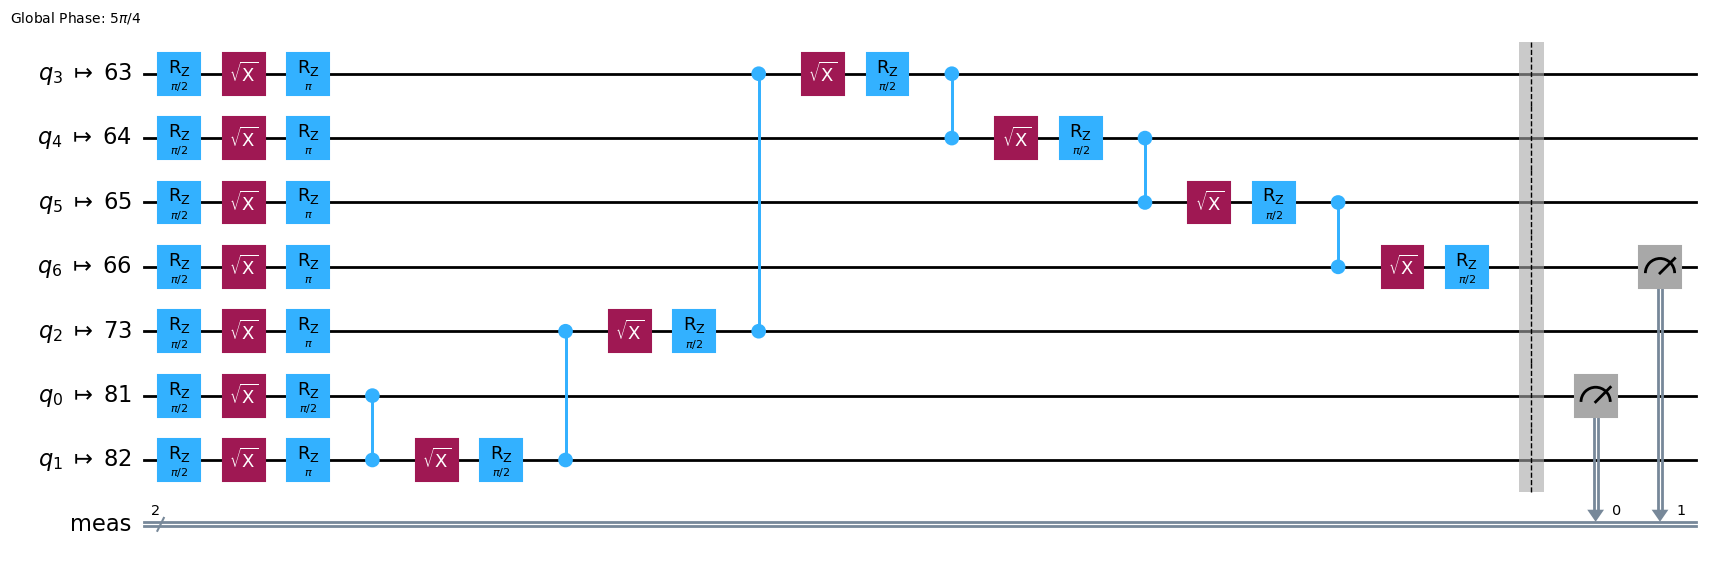

In [15]:
isa_qc.draw("mpl")

We use the layout from the transpiled circuit to find what physical qubit corresponds to the first virtual qubit in our GHZ circuit.

In [16]:
first_qubit = isa_qc.layout.initial_index_layout()[0]

We iterate over all the circuit's gates and until we find the barrier. We will use that index to insert the `reset` instruction.

In [17]:
for i, ins in enumerate(isa_qc.data):
    if ins.operation.name == "barrier":
        target_instruction = i

In [18]:
from qiskit.circuit import CircuitInstruction
from qiskit.circuit.library import Reset

We destroy the entangled state and reset the first qubit to the state $\ket{0}$.

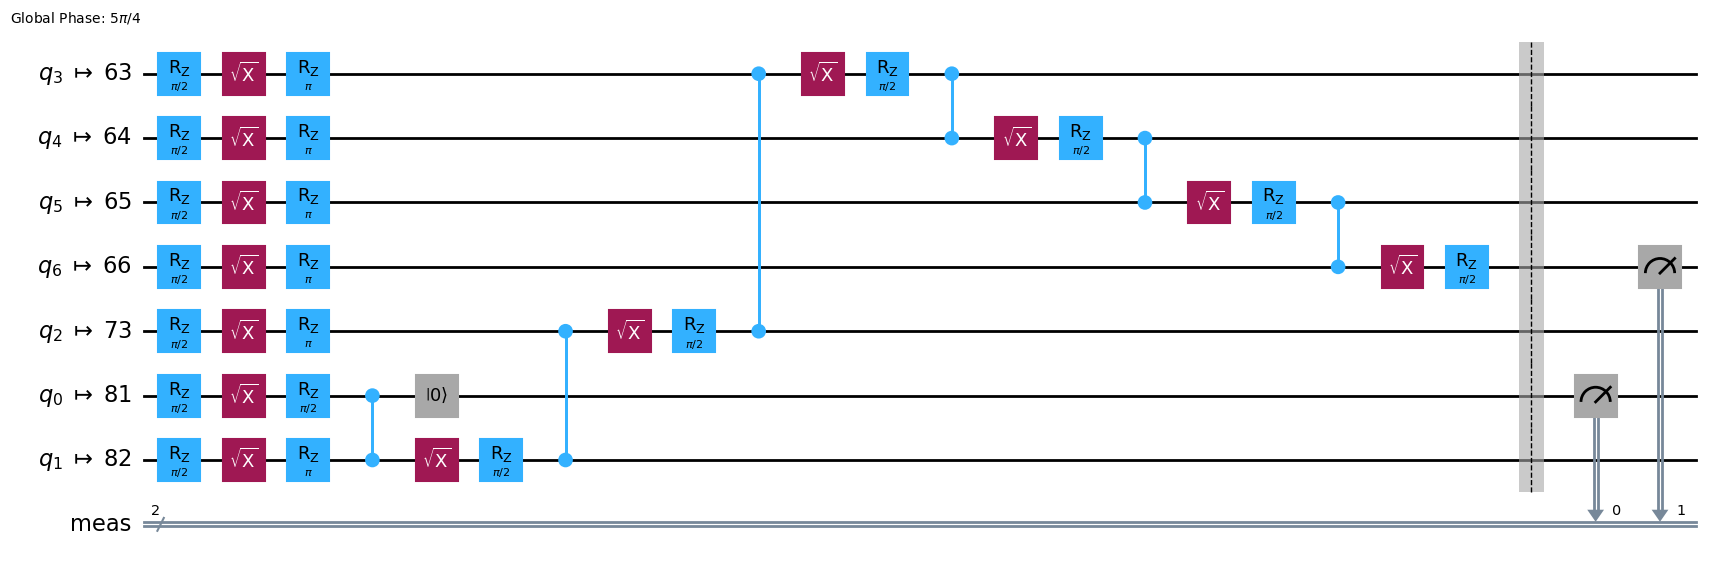

In [19]:
isa_qc_mod = isa_qc.copy()
isa_qc_mod.data.insert(target_instruction, CircuitInstruction(Reset(), qubits=[first_qubit]))
isa_qc_mod.draw("mpl")

We repeat the same experiment as before.

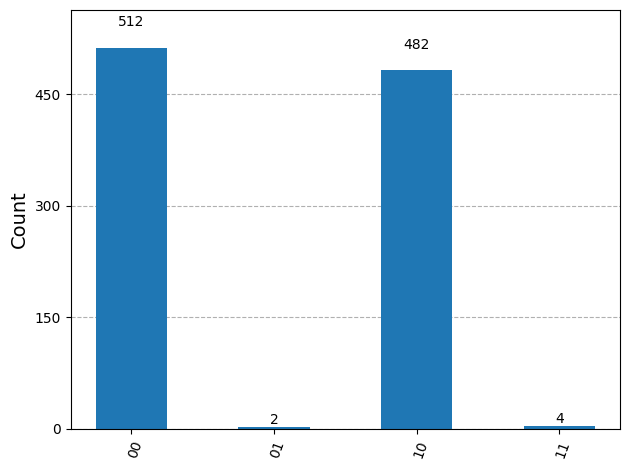

In [20]:
results = sampler_aer.run([isa_qc_mod], shots=1000).result()
counts = results[0].data.meas.get_counts()
plot_histogram(counts)

Adding that `reset` instruction completely modified the results. Since the first qubit is transformed to $\ket{0}$ just before the measurement, almost all the measurements for that qubit were 0. The very few cases where it was 1, `01` and `11`, most likeley correspond to measurement errors.

<div class="alert alert-block alert-info">

Note that Qiskit uses [a different bit-ordering convention](https://quantum.cloud.ibm.com/docs/en/guides/bit-ordering) than most textbooks so the rightmost bit in a string corresponds to the first qubit.
</div>

We repeat the experiment modifying the last qubit. We expect to obtain the exact same results but flipping the bits.

In [21]:
last_qubit = isa_qc.layout.initial_index_layout()[6]

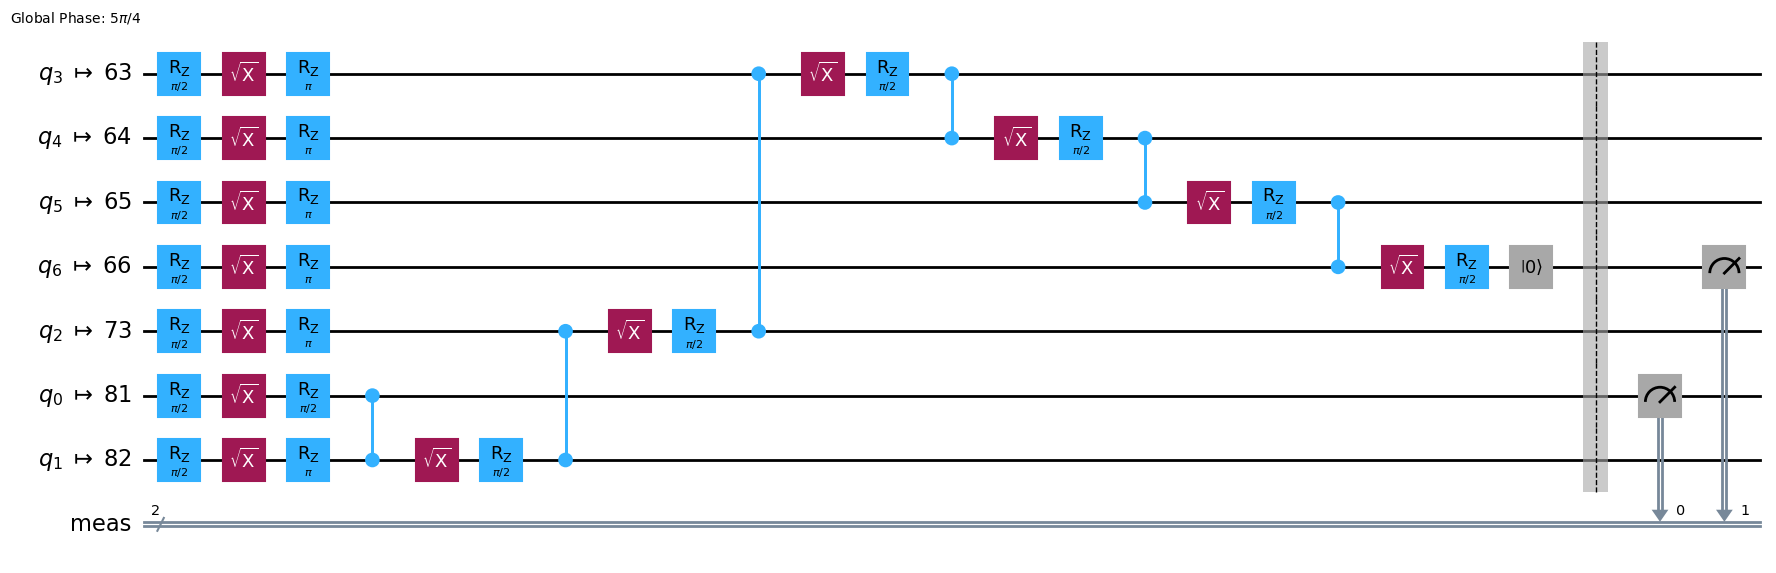

In [22]:
isa_qc_mod_alt = isa_qc.copy()
isa_qc_mod_alt.data.insert(target_instruction, CircuitInstruction(Reset(), qubits=[last_qubit]))
isa_qc_mod_alt.draw("mpl")

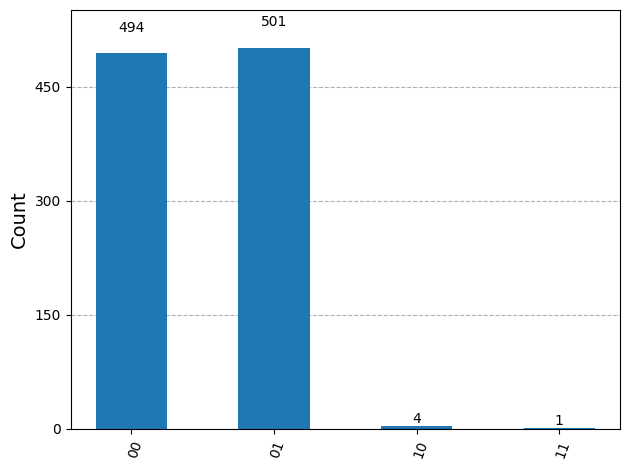

In [23]:
results = sampler_aer.run([isa_qc_mod_alt], shots=1000).result()
counts = results[0].data.meas.get_counts()
plot_histogram(counts)

And that's the case, the second qubit is almost in all cases 0, with very few errors where it was 1.

## Modifying a single CZ gate

Instead of adding an additional instruction to reset the qubit, we can also modify one of the existing controlled-Z gates so that the last qubit, for example, is not entangled to the rest of the qubits.

In [24]:
from qiskit.circuit.library import CZGate

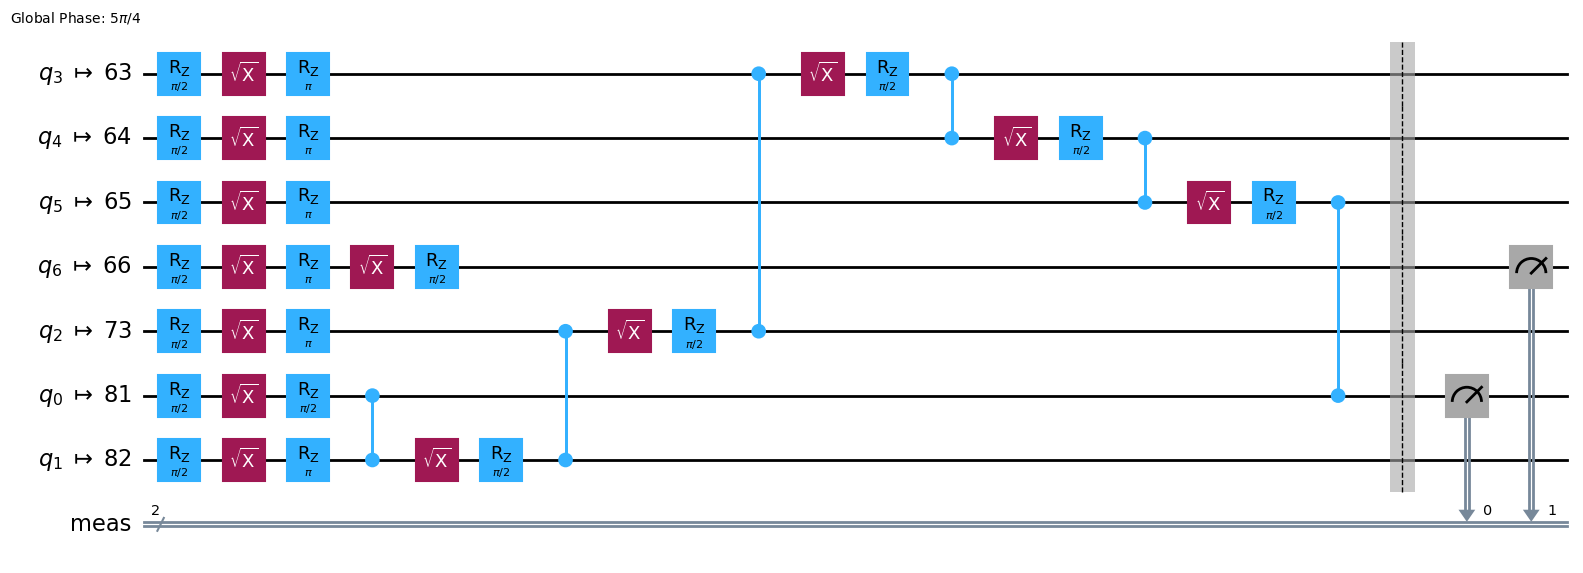

In [25]:
isa_qc_mod = isa_qc.copy()

for i, ins in enumerate(isa_qc_mod.data):
    if ins.operation.name == "cz":
        if isa_qc_mod.qubits[last_qubit] in ins.qubits:
            qubits = list(ins.qubits)
            del qubits[qubits.index(isa_qc_mod.qubits[last_qubit])]
            qubits.append(isa_qc_mod.qubits[first_qubit])
            del isa_qc_mod.data[i]
            isa_qc_mod.data.insert(i, CircuitInstruction(CZGate(), qubits=tuple(qubits)))

isa_qc_mod.draw("mpl")

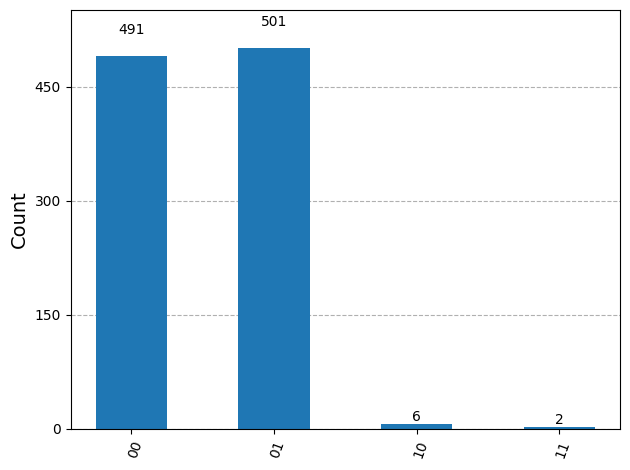

In [26]:
results = sampler_aer.run([isa_qc_mod], shots=1000).result()
counts = results[0].data.meas.get_counts()
plot_histogram(counts)

## Running on a real backend

We run the same example as shown above using the largest quantum backend available in IBM's Open Plan.

In [27]:
from qiskit_ibm_runtime import SamplerV2 as SamplerIBM

In [28]:
if run_on_ibm:
    backend = service.backend("ibm_torino")
    sampler_ibm = SamplerIBM(mode=backend)
else:
    backend = FakeTorino()

First, the trivial attack, by inserting just a single reset instruction.

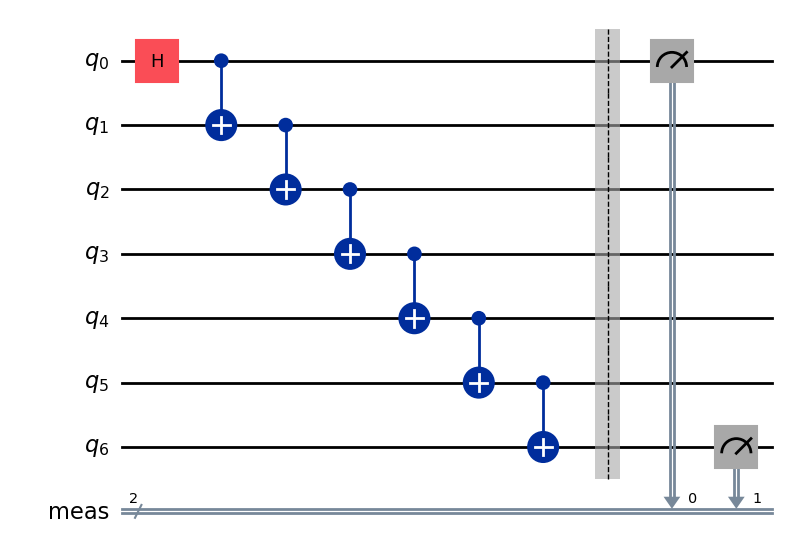

In [29]:
qc = gen_benchmarking_circuit(7)
qc.draw("mpl", fold=False)

In [30]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=3, seed_transpiler=seed_transpiler)
isa_qc = pm.run(qc)
print(f"depth transpiled circuit: {isa_qc.depth()}")
print(f"size transpiled circuit: {isa_qc.size()}")

depth transpiled circuit: 22
size transpiled circuit: 41


In [31]:
first_qubit = isa_qc.layout.initial_index_layout()[0]

for i, ins in enumerate(isa_qc.data):
    if ins.operation.name == "barrier":
        target_instruction = i
        
isa_qc_mod = isa_qc.copy()
isa_qc_mod.data.insert(target_instruction, CircuitInstruction(Reset(), qubits=[first_qubit]))

<div class="alert alert-block alert-danger">

With the default `n_shots` set at the beginning of the notebook, this job is expected to use ~7s of your IBM Open Plan monthly time.
</div>

In [32]:
if run_on_ibm:
    job = sampler_ibm.run([isa_qc, isa_qc_mod], shots=n_shots)
    job_id = job.job_id()
    print(f"job id: {job_id}")

We wait for the job to finish and obtain the counts for both the original transpiled circuit and the modified one.

In [33]:
if run_on_ibm:
    job = service.job(job_id)
    job.wait_for_final_state()
    results = job.result()
    counts_unmodified = results[0].data.meas.get_counts()
    counts_modified = results[1].data.meas.get_counts()

We can confirm the results we obtained doing a local simulation above. Adding the reset instruction completely changes the results.

In [34]:
if run_on_ibm:
    display(plot_histogram([counts_unmodified, counts_modified]))

Finally, we repeat the experiment modifying just one of the CZ gates. Note that now we cannot change the qubits arbitrarily since we have to respect the real backend's connectivity or we would get an error. For this it is useful to plot the transpiled circuit, coupling map and the circuit layout with the physical qubits.

In [35]:
from qiskit.visualization import plot_circuit_layout

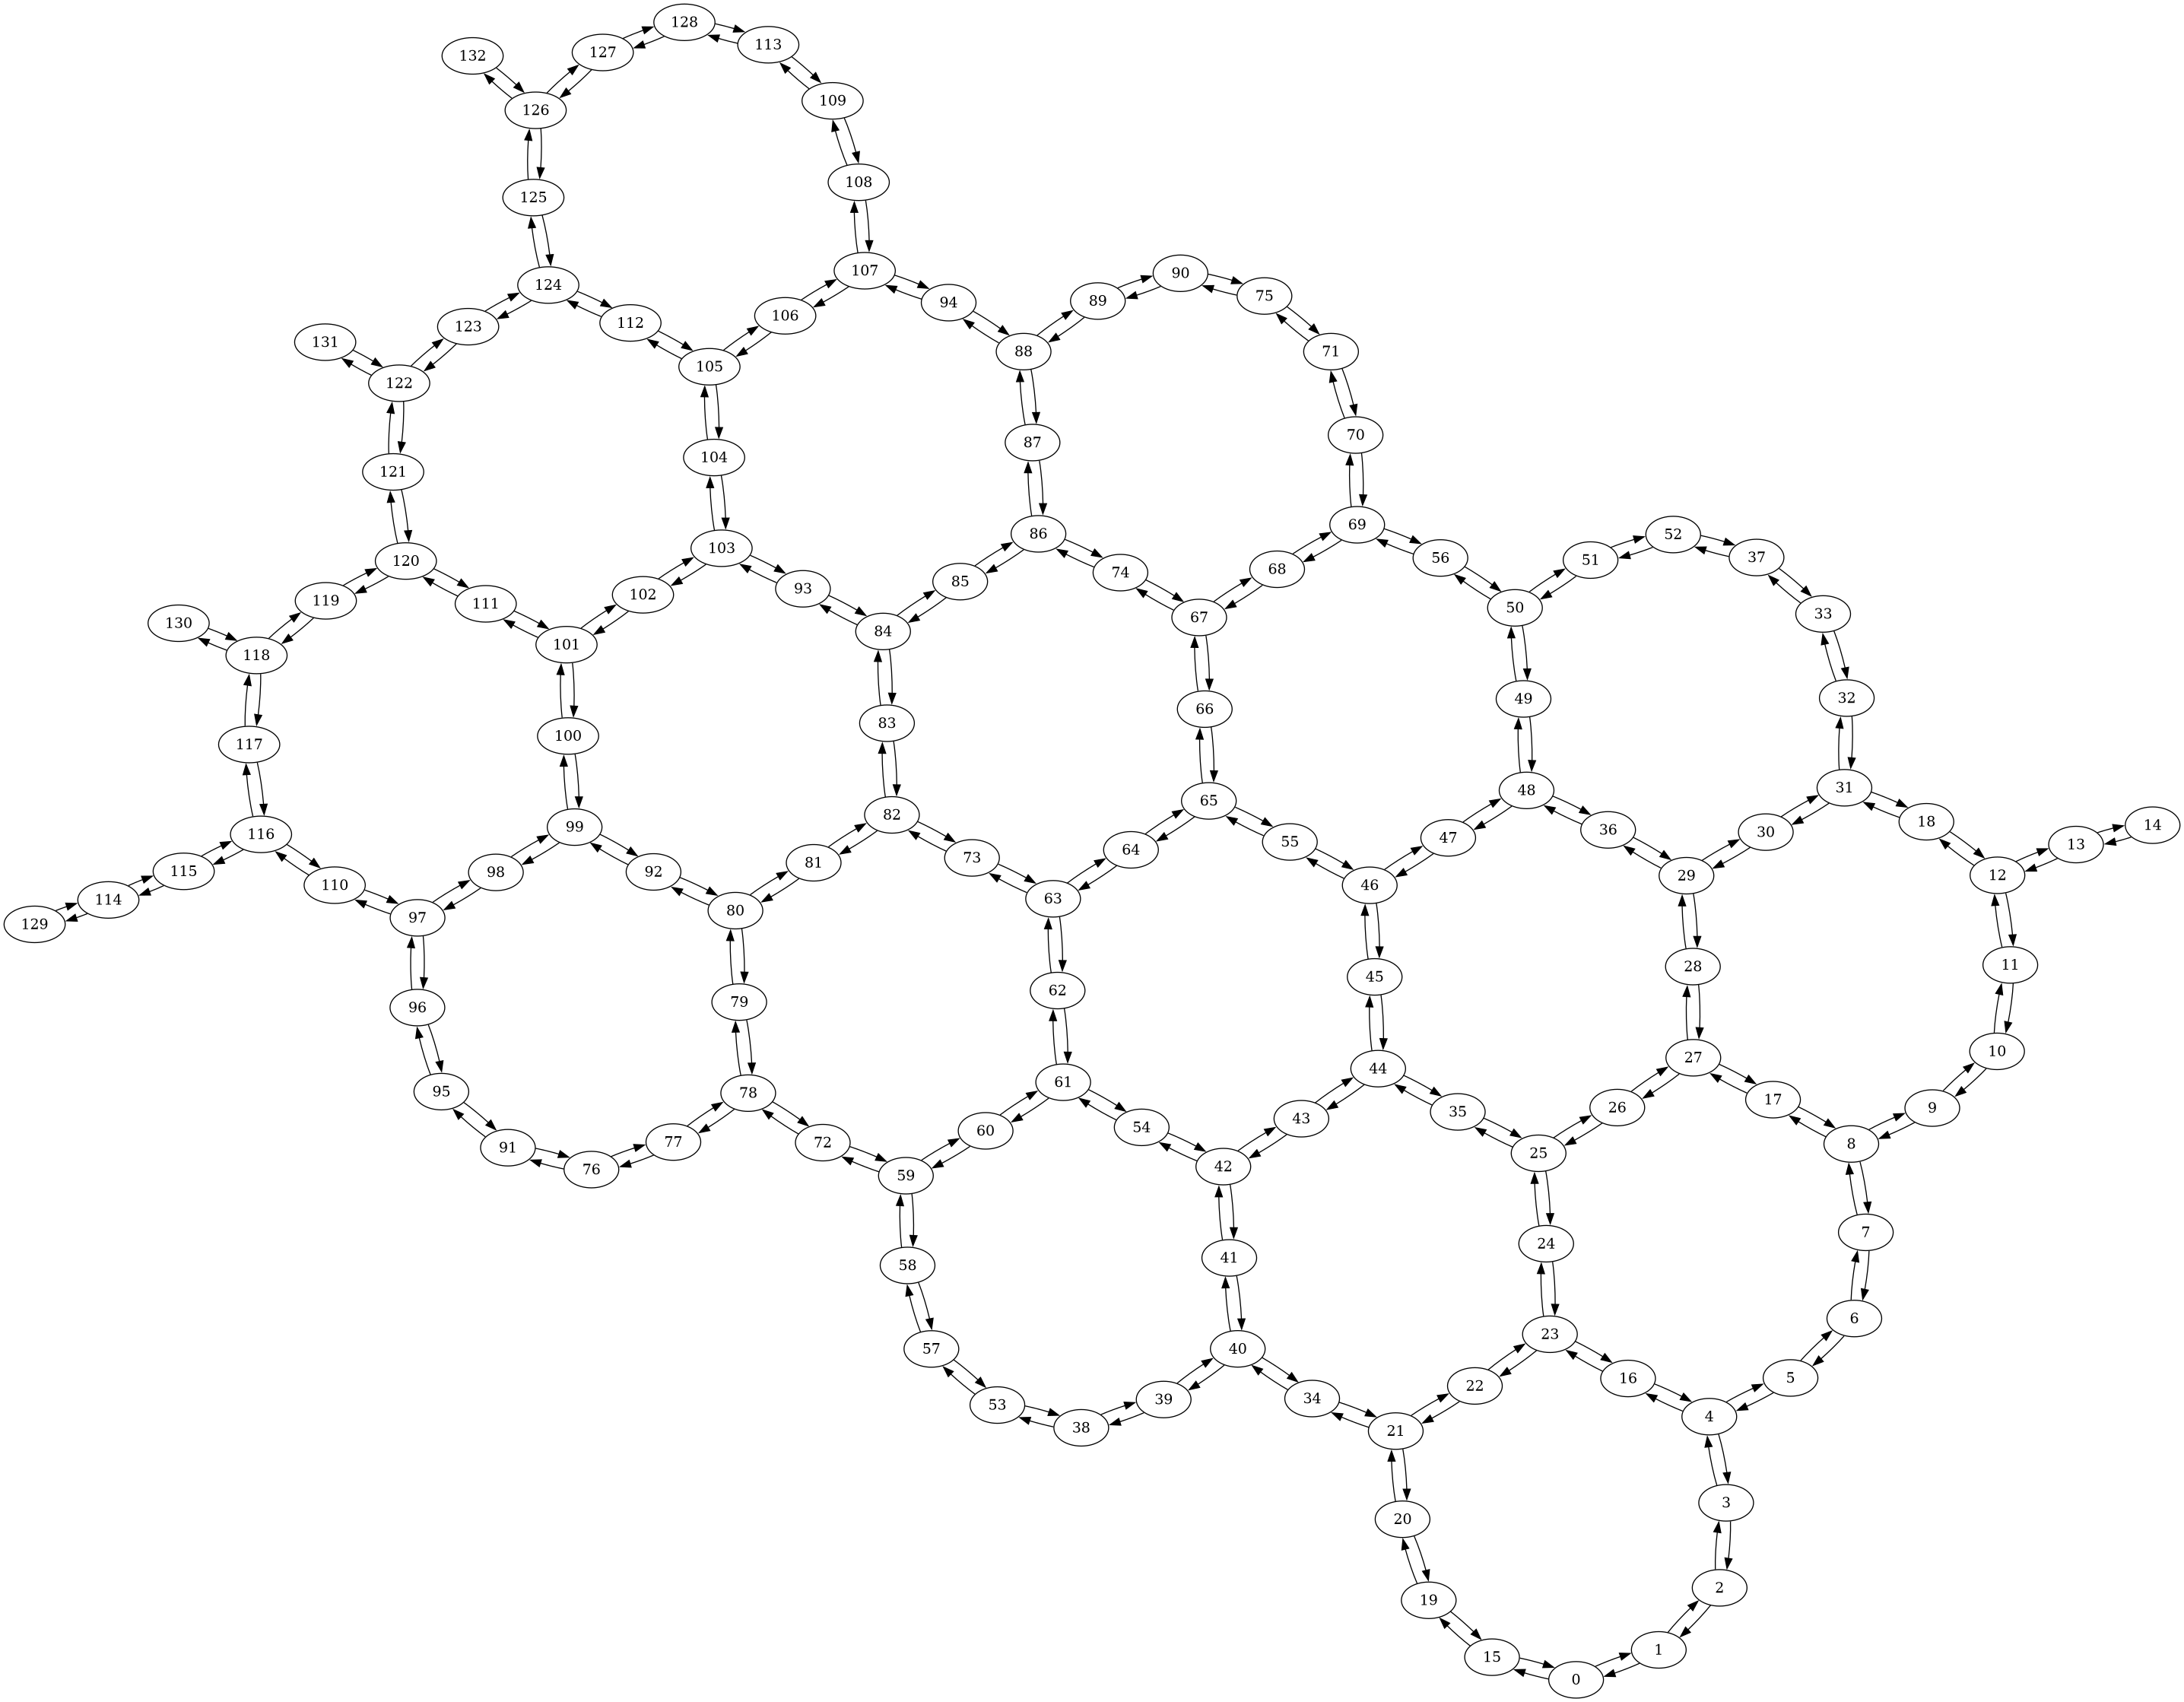

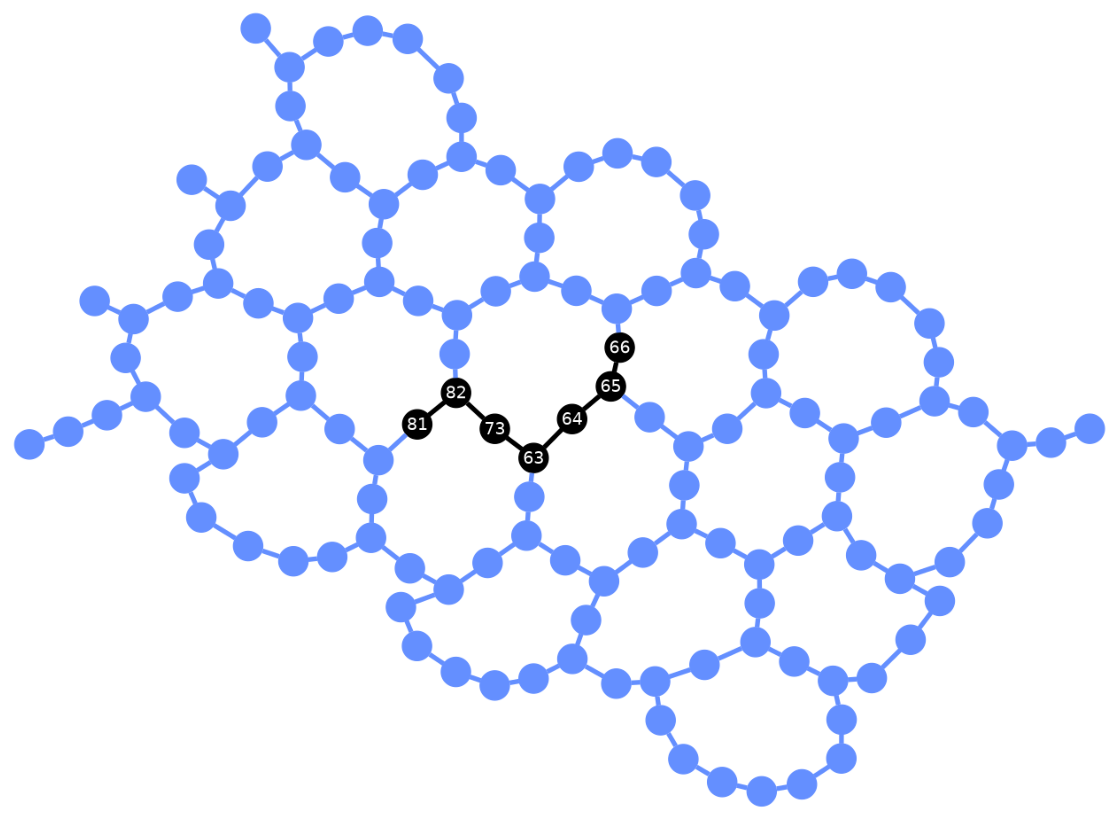

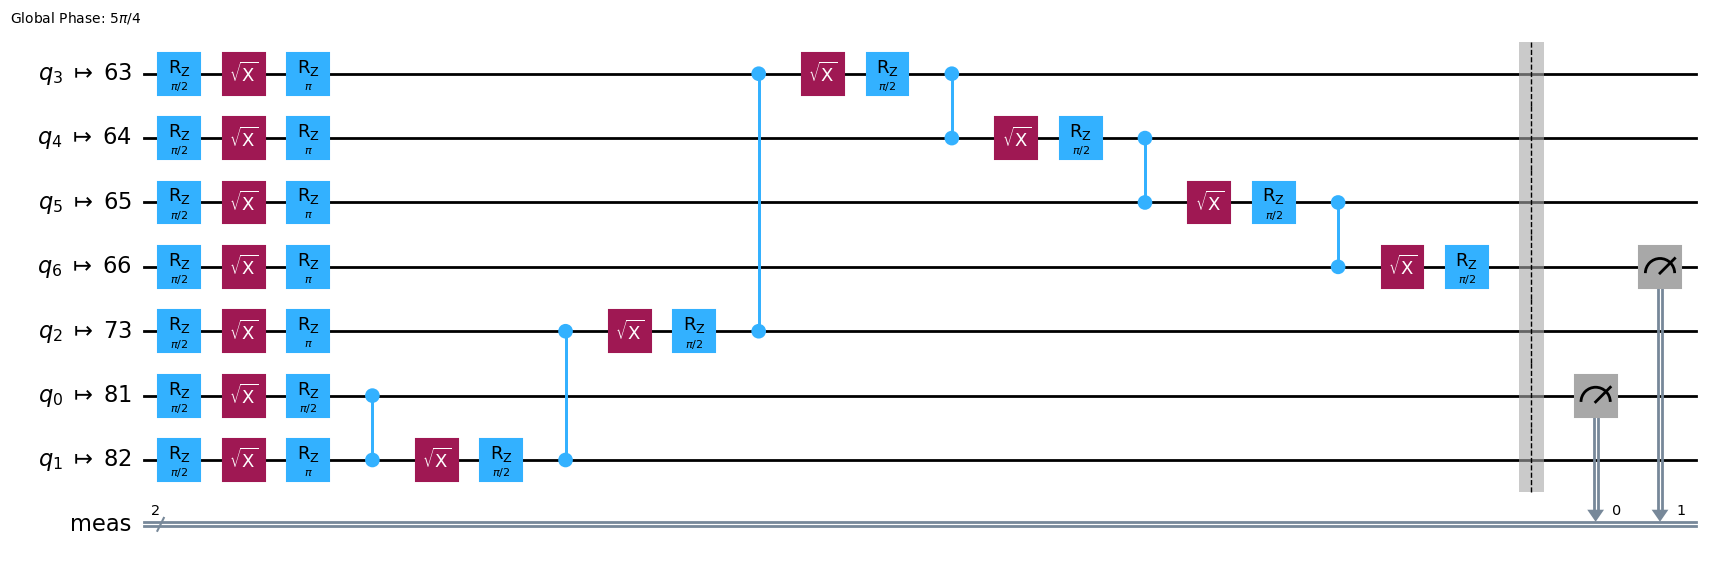

In [36]:
display(backend.coupling_map.draw())
display(plot_circuit_layout(isa_qc, backend=backend, view="physical"))
display(isa_qc.draw("mpl"))

The last qubit was mapped to qubit 81. The only CZ gate on this qubit connects it to physical qubit 82. Since 82 is one of the qubits with high connectivity, we can replace qubit 81 with qubit 73.

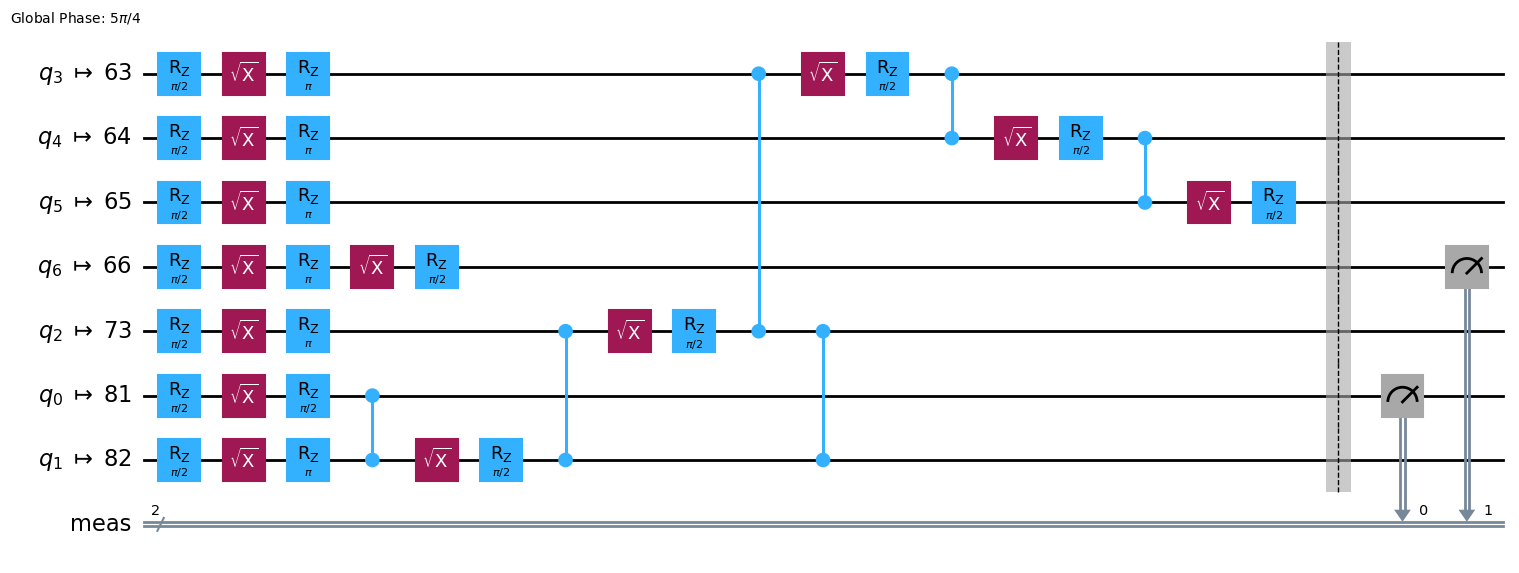

In [37]:
isa_qc_mod = isa_qc.copy()

for i, ins in enumerate(isa_qc_mod.data):
    if ins.operation.name == "cz":
        if isa_qc_mod.qubits[last_qubit] in ins.qubits:
            del isa_qc_mod.data[i]
            isa_qc_mod.data.insert(i, CircuitInstruction(CZGate(), qubits=tuple([isa_qc_mod.qubits[82], isa_qc_mod.qubits[73]])))

isa_qc_mod.draw("mpl")

<div class="alert alert-block alert-danger">

With the default `n_shots` set at the beginning of the notebook, this job is expected to use ~7s of your IBM Open Plan monthly time.
</div>

In [38]:
if run_on_ibm:
    job = sampler_ibm.run([isa_qc, isa_qc_mod], shots=n_shots)
    job_id = job.job_id()
    print(f"job id: {job_id}")

In [39]:
if run_on_ibm:
    job = service.job(job_id)
    job.wait_for_final_state()
    results = job.result()
    counts_unmodified = results[0].data.meas.get_counts()
    counts_modified = results[1].data.meas.get_counts()

In [40]:
if run_on_ibm:
    display(plot_histogram([counts_unmodified, counts_modified]))